<a href="https://colab.research.google.com/github/jahanshukhy/Intro-to-Machine-Learning/blob/main/HW6_prb3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports & device
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [3]:
# Download CIFAR-10, convert to tensor and normalize

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    ),
])

data_path = './data-cifar10/'

cifar10_train = datasets.CIFAR10(
    root=data_path, train=True,  download=True, transform=transform
)
cifar10_val = datasets.CIFAR10(
    root=data_path, train=False, download=True, transform=transform
)

print("Train size:", len(cifar10_train))
print("Val size  :", len(cifar10_val))



100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


Train size: 50000
Val size  : 10000


In [5]:
# DataLoaders
batch_size = 128

train_loader = DataLoader(
    cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    cifar10_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

# Define fully connected NN (1 hidden layer, 512 units)
# CIFAR-10 images are 3 x 32 x 32 = 3072 features when flattened.

class FCNet1Hidden(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dim=512, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # logits for 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # CrossEntropyLoss will apply Softmax internally

model = FCNet1Hidden().to(device)
print(model)

# Loss function & optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop

num_epochs = 50
train_losses = []
val_losses   = []
train_accuracies = []
val_accuracies   = []

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    model.train()

    running_loss = 0.0
    total_train = 0
    correct_train = 0
    val_running_loss = 0.0

    # Training over all mini-batches
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)               # logits: [batch, 10]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)


        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    avg_train_loss = running_loss / total_train
    train_acc = correct_train / total_train

    # Evaluation on validation (test) set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_val_loss = val_running_loss / total
    val_acc = correct / total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


    epoch_time = time.time() - start_time

    print(f"Epoch {epoch:3d} | "
          f"Time: {epoch_time:6.2f} s | "
          f"Train loss: {avg_train_loss:.4f} | "
          f"Train acc: {train_acc:.4f} | "
          f"Val acc: {val_acc:.4f}")


FCNet1Hidden(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Epoch   1 | Time:   7.74 s | Train loss: 1.7007 | Train acc: 0.4144 | Val acc: 0.4396
Epoch   2 | Time:   7.07 s | Train loss: 1.4732 | Train acc: 0.4883 | Val acc: 0.4787
Epoch   3 | Time:   7.26 s | Train loss: 1.3963 | Train acc: 0.5172 | Val acc: 0.4935
Epoch   4 | Time:   6.93 s | Train loss: 1.3135 | Train acc: 0.5473 | Val acc: 0.4953
Epoch   5 | Time:   7.12 s | Train loss: 1.2747 | Train acc: 0.5634 | Val acc: 0.5022
Epoch   6 | Time:   7.03 s | Train loss: 1.2090 | Train acc: 0.5844 | Val acc: 0.5217
Epoch   7 | Time:   7.19 s | Train loss: 1.1587 | Train acc: 0.6046 | Val acc: 0.5090
Epoch   8 | Time:   7.07 s | Train loss: 1.1134 | Train acc: 0.6196 | Val acc: 0.5169
Epoch   9 | Time:   7.18 s | Train loss: 1.0465 | Train acc: 0.6434 | Val acc: 0.5133
Epoch  10 | Time:   7.2

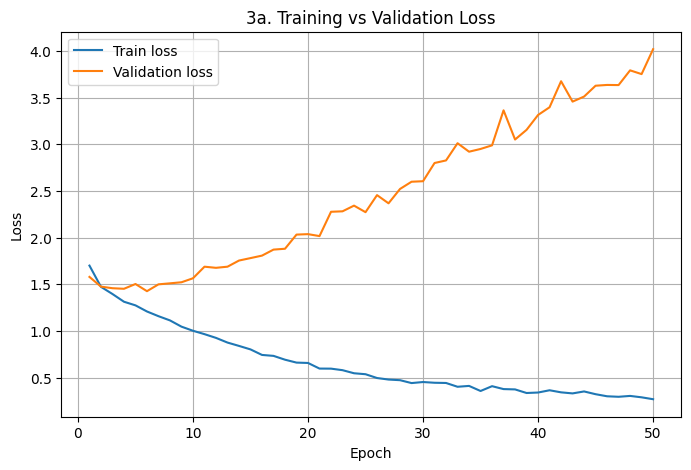

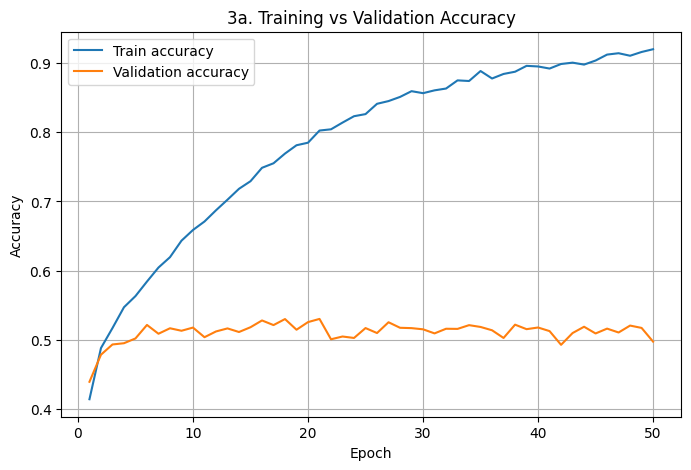

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot loss
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train loss')
plt.plot(epochs, val_losses,   label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('3a. Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs, train_accuracies, label='Train accuracy')
plt.plot(epochs, val_accuracies,   label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('3a. Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU name: NVIDIA L4


In [11]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

param_3a = count_params(model)
print("Number of trainable parameters in 3b model:", param_3a)

Number of trainable parameters in 3b model: 1578506
